# 重回帰分析

In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import wooldridge
from see import see
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from pandas.plotting import scatter_matrix
import seaborn as sns

## 説明

説明変数が複数の重回帰分析（Multiple Regression）を考える。

$$y_i=\beta_0+\sum_{j=1}^k\beta_j x_{ij} + u_i$$
* $i=1,2,...n$：観測値のインデックス
* $j=1,2,...k$：説明変数の数

（注意）

$x_1$と書く場合，$x_{i1},x_{i1},...x_{n1}$を表す（第１番目の説明変数）。

一般的に$x_j$と書く場合，$x_{ij},x_{ij},...x_{nj}$を表す（第$j$番目の説明変数）。

## `statsmodels`を使う

### 推定

単回帰分析で使った同じデータセット`wage1`を使い，賃金と教育の関係を再考する。前章と異なる点は，複数の説明変数を導入し重回帰分析をおこなうことである。追加的な説明変数として`exper`と`tenure`を加える。`statsmodels`を使う上で単回帰と異なる点は，それぞれの説明変数の前に`+`を追加するだけである。

必要な変数だけを取り出し変数`wage1`に割り当てる。

In [2]:
wage1 = wooldridge.data('wage1').loc[:,['wage', 'educ', 'tenure', 'exper']]

In [3]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

回帰式では，それぞれの説明変数の前に`+`を付ける。

In [4]:
formula_1 = 'np.log(wage) ~ educ + tenure + exper'

推計結果を変数`res_1`に割り当てる。

In [5]:
res_1 = ols(formula_1, data=wage1).fit()

### 属性とメソッド

推定結果`res_1`の属性とメソッドは`dir()`や`see()`で確認できる。

In [6]:
see(res_1)

    <                    <=                   ==                   !=
    >                    >=                   dir()                hash()
    help()               repr()               str()                .HC0_se
    .HC1_se              .HC2_se              .HC3_se              .aic
    .bic                 .bse                 .centered_tss
    .compare_f_test()    .compare_lm_test()
    .compare_lr_test()                        .condition_number    .conf_int()
    .conf_int_el()       .cov_HC0             .cov_HC1             .cov_HC2
    .cov_HC3             .cov_kwds            .cov_params()        .cov_type
    .df_model            .df_resid            .eigenvals           .el_test()
    .ess                 .f_pvalue            .f_test()
    .fittedvalues        .fvalue              .get_influence()
    .get_prediction()    .get_robustcov_results()
    .initialize()        .k_constant          .llf                 .load()
    .model               .mse_model           .mse_

係数の推定値は属性`.params`で取得できる。

In [7]:
res_1.params

Intercept    0.284360
educ         0.092029
tenure       0.022067
exper        0.004121
dtype: float64

`educ`の係数だけを取り出す場合：

In [8]:
res_1.params[1]

0.09202898676928312

次に，メソッド`predict()`を使って予測値を計算する場合を考えよう。例えば，`educ`, `tenure`, `exper`の平均値での`np.log(wage)`を計算しよう。

In [9]:
wm = wage1.mean()  # 変数の平均の計算
wm

wage       5.896103
educ      12.562738
tenure     5.104563
exper     17.017110
dtype: float64

`wm`は`Series`なので`wm['educ']`で`educ`の平均値だけを取り出すことができる。

In [10]:
wm['educ']

12.562737642585551

`predict()`に渡す引数として説明変数の`DataFrame`を作るのが一番簡単であろう。

（注意）以下のコードでは辞書の値が`wm['educ']`ではなく`[wm['educ']]`となっている点に注意しよう。これは`DataFrame`を作成する場合，単なる値ではなく`list`や`array`にして値として使う必要があるためである。

In [11]:
z = pd.DataFrame({'educ':[wm['educ']],
                  'tenure':[wm['tenure']],
                  'exper':[wm['exper']]})

In [12]:
res_1.predict(z)

0    1.623268
dtype: float64

複数の予測値を計算するには、辞書の値にある`list`や`array`に複数の要素を書き込む。次の例では、`tenure`と`exper`を平均値に固定し、`educ`を平均値、平均値の0.5倍の値、平均値の1.5倍の値に変化させて予測値を計算している。

In [13]:
educ_mean = wm['educ']
tenure_mean = wm['tenure']
exper_mean = wm['exper']

z2 = pd.DataFrame({'educ':[educ_mean*0.5, educ_mean, educ_mean*1.5],
                  'tenure':[tenure_mean]*3,
                  'exper':[exper_mean]*3})
res_1.predict(z2)

0    1.045200
1    1.623268
2    2.201336
dtype: float64

（コメント）

* 引数を省略すると予測値を返す属性`.fittedvalues`と同じ値を返す。それを確かめるために次のコードを評価してみる。

In [14]:
len(wage1) == (res_1.predict() == res_1.fittedvalues).sum()

True

* 左辺
    * 被説明変数の数を返す。

* 右辺
    * `res_1.predict() == res_1.fittedvalues`の意味
        * `res_1.predict()`と`res_1.fittedvalues`はSeriesを返すので，`==`で比較することにより，それぞれの対応する値が等しければ`True`異なれば`False`になるSeriesを返す。
    * `sum()`はSeriesの`True`の数を数える。
        * `res_1.predict() == res_1.fittedvalues`を`()`で囲んでいるのは，カッコ内を先に評価する必要があるためである。
    * 右辺は`res_1.predict()`と`res_1.fittedvalues`の対応する値が等しい数を返す。

## 変数の変換

上の重回帰分析では，回帰式の被説明変数が対数変換されているが，この手法は説明変数にも使うことができる。また以下の方法も被説明変数・説明変数の両方に使用可能である。
* `I()`の`()`の中に直接式を書く。
* `def`を使い定義した関数を使う。

### `I()`を使う方法

`exper`の二乗を回帰式に入れるケースを考えよう。

In [15]:
formula_2 = 'np.log(wage) ~ educ + tenure + exper + I(exper**2)'
res_2 = ols(formula_2, data=wage1).fit()

In [16]:
res_2.params

Intercept        0.198345
educ             0.085349
tenure           0.020841
exper            0.032854
I(exper ** 2)   -0.000661
dtype: float64

### `def`を使う方法

`exper`の二乗を回帰式に入れるケースを考えよう。

In [17]:
def myfunc(x):
    return x**2

In [18]:
formula_3 = 'np.log(wage) ~ educ + exper + tenure + myfunc(exper)'
res_3 = ols(formula_3, data=wage1).fit()

In [19]:
res_3.params

Intercept        0.198345
educ             0.085349
exper            0.032854
tenure           0.020841
myfunc(exper)   -0.000661
dtype: float64

## 係数の解釈

次の推定式を考える。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+\beta_3x_3+u$$

＜解釈１：Ceteris Paribus＞

$x_1$以外の変数を固定して$x_1$だけを少しだけ変化させると，$y$に対する影響を次のように表すことができる。

$$\dfrac{\Delta y}{\Delta x_1}=\beta_1$$

ここで
* $\Delta x_1=x_1$の変化（１単位の変化と解釈する） 
* $\Delta y=y$の変化 
であり，その比率が$x_1$の$y$に対する効果と考える。重要な点は，$x_1$以外の変数は固定されていることである。これをCeteris Paribus (ラテン語; "other things being equal"という意味)と呼ぶ。

＜解釈２：影響の除去＞

まず$y$と$x_1$の関係を捉える$\hat{\beta}_1$を考えよう。もし推定式に$x_2$と$x_3$が入っていなければ，$\hat{\beta}_1$は$x_2$と$x_3$の影響を拾うことになる（$x_1$が$x_2$と$x_3$のそれぞれと完全に無相関でない場合）。即ち，$x_2$と$x_3$が入ることにより，$\hat{\beta}_1$はこれらの変数の影響を「除去」した後に残る$y$と$x_1$の関係を捉えていると考えることができる。同じように，$\hat{\beta}_j$は$j$以外の説明変数の影響を取り除いた後に残る$y$と$x_j$の関係を示している。

---
`wage1`を使い以下を推定するとしよう。

In [20]:
formula_1a = 'wage ~ educ + tenure + exper'
res_1a = ols(formula_1a, data=wage1).fit()
res_1a.params

Intercept   -2.872735
educ         0.598965
tenure       0.169269
exper        0.022340
dtype: float64

`tenure`と`exper`を固定して，`educ`を一単位増加させるとしよう。その効果は

$$\dfrac{\Delta\text{wage}}{\Delta\text{educ}}\approx 0.599$$

即ち，教育期間が一単位（ここでは一年）増えると賃金は0.599ドル増加することを示している。

---
次に`formula_1`の回帰式を使って推定した`res_1`を考えよう。この場合，

$$\dfrac{\Delta\ln(\text{wage})}{\Delta\text{educ}}\approx 0.092$$

対数の性質を使い左辺は次のように書き換えることができる。

$$\dfrac{\Delta\ln(\text{wage})}{\Delta\text{educ}}
=\dfrac{\Delta\text{wage}/\text{wage}}{\Delta\text{educ}}
=\dfrac{\%\Delta\text{wage}}{\Delta\text{educ}}
$$

ここで，$\%\Delta\text{wage}=$％で表した
`wage`の変化。従って，教育期間が一単位（ここでは一年）増えると賃金は約9.2%増加することを示している。

## ガウス・マルコフ定理

### 母集団回帰式と標本回帰式

今までは回帰式に基づいて`Python`を使い係数の推定方法を説明したが，ここではOLS推定量の望ましい性質とはなにか，望ましい性質の条件はなにかを考える。そのために，まず母集団回帰式と標本回帰式について説明する。

計量経済学では，データを使い**経済理論（経済学的な考え）**
に基づいた仮説を検証する。例として「消費は家計の所得$x_1$が高くなると増えるが，子どもの数$x_2$と反比例する」という仮説を考える。所得と子どもの数に依存する消費の部分だけを$y^*$と書くと，一般型の消費関数は$y^*=f\left(x_1,x_2\right)$となる。更に，線形を仮定すると次式となる。

$$y^*=\beta_0+\beta_1x_1+\beta_2x_2\qquad{(式１)}$$

例えば，所得30万円，子ども2人の家計の場合、消費は$\beta_0+\beta_1\cdot\left(\text{30万円}\right)+\beta_2\cdot\left(\text{2人}\right)$となる。所得 $x_1$が変化すると消費$y^*$も変化することが分かる。このことは$\beta_2=0$の単回帰の場合（消費が子供の数に依存しない場合）を考えればもっと分かりやすいだろう。その場合，(式１)は

$$y^*=\beta_0+\beta_1x_1$$

となり，横軸に$x_1$，縦軸に$y^*$を置く図では右上がりの直線となる。

(式１)は**平均**の家計の行動を表していると考えることができる。従って，同じ所得と子どもの数の家計でも好み等の要因が違うと消費に違いがでる。その違いを（平均ゼロの）誤差項$u$として捉えると，全ての家計の消費 $y$は次式で表すことができる。

$$y=y^*+u\qquad{(式２)}$$

* $y^*$：平均の家計の消費であり，$x_1$と$x_2$のみに依存する部分
* $u$：平均の家計と異なる家計の消費であり，平均家計との違いを捉える部分

(式１)を(式２)に代入すると

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u\qquad{(式３)}$$

となる。この式は仮説に基づいた関係式であり，**母集団回帰式**と呼ばれる。また(式３)を使い$x_1$と$x_2$を所与として期待値を計算すると次式を得る。

$$\text{E}\left(y|x_1,x_2\right)=y^*\qquad\because\;\text{E}(u)=0$$

これは「$x_1$と$x_2$を所与とする」という条件の下での期待値なので**条件付き期待値**（conditional expectations）と呼ばれる。この式は，$y$の条件付き期待値は母集団回帰式の$x_1$と$x_2$に依存する部分である$y^*$と等しいことを示している。即ち，（式１）は母集団で平均として成立する**母集団回帰線**を表している。

---
（注意点）

* 母集団回帰式(式３)は理論的な仮定に基づいて導出したため，それが正しいかどうかは事前に分からない。
* 母集団パラメータ$\beta_j$, $j=0,1,2$と誤差項$u$は**観測できない**。

---
母集団回帰式(式３)が成立するという**仮定**のもとで母集団パラメータ$\beta_j$，$j=0,1,2$を推定することになる。そのためには，
* $\left\{y_i,x_{i1},x_{i2}\right\}$, $i=1,2,..,n$ の標本を収集する。
* 次式に重回帰分析の手法を適用しOLS推定値を計算する。

    $$y_i=\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+u_i,\qquad i=1,2,..,n\qquad{(式４)}$$

母集団回帰式(式３)と区別するために，この式には添え字$i$があり**標本回帰式**と呼ぶ。

（注意点）

* 通常，標本の大きさは母集団のそれよりも小さい。従って，パラメータのOLS推定値$\hat{\beta}_j$には誤差が発生する。即ち，必ずしも$\hat{\beta}_j=\beta_j$, $j=0,1,2$とはならない。

一方で，上で述べたようにOLS推定量には何らかの「望ましい性質」がある。
1. 「望ましい性質」の前提となる条件は何なのか？ 
1. OLS推定量の「望ましい性質」とは何なのか？

以下では１から考える。

### 仮定と望ましい性質

* 仮定１：Linear in parameters（母集団回帰式の線形性）
    * 母集団のモデルは次式のようにパラメータに関して線形である。
    
        $$
        y=\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_kx_k+u
        $$

    * $y=\beta_0+\beta_1x_1+\beta_2x_1^2$は線形性を満たす。
    * $y=\beta_0+\dfrac{\beta_1}{1+\beta_2x_1}+\beta_3x_2$は線形性を満たさない。

* 仮定２：Random Sampling（標本の無作為抽出）
    * 無作為に$\left\{y_i,x_{i1},,x_{i2},...,,x_{ik}\right\}$, $i=1,2,...,n$が抽出される。
    * 多くの横断面データでは成立すると考えられている（時系列データでは満たされない場合が多い）。
    * この仮定により
    
        $$\text{Corr}\left(u_i,u_j|X\right)=0,\;i\neq j,\qquad X=\{x_1,x_2,...x_k\}$$
        
        となる。つまり，説明変数$X$を所与として$u_i$と$u_j$は何の関係もないという意味である。

* 仮定３：No perfect collinearity（母集団回帰式の説明変数の非完全多重共線性）
    * 説明変数$x_j$が他の説明変数の完全な線形結合（例えば，$x_2=1+2x_1$や$x_1=x_2+5x_4$）として表すことができないという意味。もしこの仮定が満たされなければ$x_j$は何の追加的な情報を持たないため。
    * 定数項以外の説明変数が全く変化しないことも排除（例えば，$x_j=3$）。このような変数は定数項の単なるスケールアップ・バージョンであり，追加的な情報はない。（定数項以外の説明変数は変化してこそ$y$を説明できる。）

* 仮定４：Zero conditional mean（母集団回帰式の誤差項の条件付き期待値は０）

    $$\text{E}\left(u|X\right)=0,\qquad X=\{x_1,x_2,...x_k\}$$
    
    * 説明変数の値は誤差項の平均に影響を与えないことを意味しており，$X$は$u$に対して何の情報も影響力も全くないということである。即ち，$X$がどのような値を取ったとしても，$u$の平均は0だということである。ではなぜ$|X$を付け加えるのか。実は，$\text{E}\left(u|X\right)=0$は$\text{E}(u)=0$を意味する。しかし後者は前者を意味しない。$\text{E}(u)=0$は単純に平均がゼロであることを示しているだけで，$X$と$u$の関係について何も語っていないためである。$X$と$u$が線形・非線形な関係が無いことを明確にするために$|X$を付け加えている。
    * $x_1$と$x_2$を所与として(式３)の期待値を計算すると次式を得る。
    
    $$
    \text{E}\left(y|x_1,x_2\right)=\beta_0+\beta_1x_1+\beta_2x_2=y^*,
    \qquad\because\;
    \text{E}\left(u|x_1,x_2\right)=0
    $$
    
     消費の条件付き期待値は，説明変数（所得と子どもの数）だけに依存する消費の部分$y^*$（母集団回帰関数）と等しい。

---
仮定１〜４の下で母集団パラメータのOLS推定量は不偏性（unbiasedness）を満たす。

$$\text{E}\left(\hat{\beta}_j\right)=\beta_j,\qquad j=0,1,2,...,k$$

（解釈）

標本の大きさが$n$の標本を使い回帰分析をおこない$\hat{\beta}_j$を得たとしよう。さらに同じ標本の大きさ$n$の異なる標本を使い回帰分析を合計$N$回おこない$\hat{\beta}_j$を計算したとしよう。不偏性とは$N$が十分に大きい場合（$N\rightarrow\infty$），$N$個ある$\hat{\beta}_j$の平均は$\beta_j$と等しいという性質である。

（注意点）

この結果は標本の大きさ$n$に依存しない。即ち，大標本（$n\rightarrow\infty$）である必要はない。むしろ小標本（$n<\infty$）で重要視される小標本特性（データが少ない場合の特性）と考えるべきである。

---
* 仮定５：Homoskedasticity（均一分散; 母集団回帰式の説明変数は誤差項の分散に影響を与えない）

$$\text{Var}\left(u|X\right)=\sigma^2$$

---
仮定１〜５をガウス・マルコフ仮定（横断回帰分析のGM仮定）と呼び，この下では以下が成立する。
1. 誤差分散の推定量 $\hat{\sigma}^2$の平均は母集団の値と等しい（誤差分散の不偏推定量）。

    $$
    \text{E}\left(\hat{\sigma}^2\right)=\sigma^2
    $$

    ここで，$\hat{\sigma}^2=\dfrac{\sum_{i=1}^n\hat{u}_i^2}{n-k-1}=\dfrac{SSR}{n-k-1}$
    であり，$\hat{u}_i=y_i-\hat{y}_i$はOLS残差であり，$SSR$は残差の二乗平方和。$\hat{\sigma}$にはさまざまな呼称があり，the Standard Error of Regression, the Standard Error of the Estimate, the Root Mean Squared Errorがある。

2. OLS係数の（標本）分散の推定量（$\sigma^2$に$\hat{\sigma}^2$代入されている）

    $$
    \widehat{\text{Var}}\left(\hat{\beta}_j\right)
    =\dfrac{\hat{\sigma}^2}{SST_j\left(1-R_j^2\right)}
    =\dfrac{1}{n-1}\cdot
    \dfrac{\hat{\sigma}^2}{\text{Var}(x_j)}\cdot
    \dfrac{1}{1-R_j^2}
    $$

    ここで，$\text{Var}(x_j)=(n-1)^{-1}\sum_{i=1}^n\left(x_{ij}-\overline{x}_j\right)$であり，$R_j^2$は$x_j$を他の全ての説明変数に回帰分析する際の決定係数である。
    $\widehat{\text{Var}}\left(\hat{\beta}_j\right)$はOLS推定量$\hat{\beta}_j$の正確性を捉え，低ければより高い正確性を示す。（「なぜ分散？」と思う場合は前章のシミュレーション１で，標本のランダム抽出を行うたびに，$\hat{\beta}$の値が変わったことを思い出そう。）

---
パラメータの分散の推定値の式から以下が分かる。
* $\dfrac{1}{n-1}$: 標本の大きさが大きくなると$\hat{\beta}_j$の正確性を高める。
* $\dfrac{\hat{\sigma}^2}{\text{Var}(x_j)}$: 残差の分散に対して説明変数$x_j$の分散が大きければ，$\hat{\beta}_j$の正確性を高める。
* $R_j^2$は多重共線性が高くなると大きくなる。従って，多重共線性が高いと$\hat{\beta}_j$の正確性を低下させる。

---
$\widehat{\text{Var}}\left(\hat{\beta}_j\right)$のルートは**OLS推定量の標準誤差**と呼ぶ（パラメータの推定値の標準偏差）。

$$
\text{se}\left(\hat{\beta}_j\right)
=\sqrt{\widehat{\text{Var}}\left(\hat{\beta}_j\right)}
=\dfrac{1}{\sqrt{n-1}}\cdot
\dfrac{\hat{\sigma}}{\text{sd}(x_j)}\cdot
\dfrac{1}{\sqrt{1-R_j^2}}
$$

この結果は推定結果の検定や信頼区間を計算する際に必要となる。

---
**ガウス・マルコフ定理**（望ましい性質）

GM仮定１〜５のもとで`OLS`推定量はB.L.U.E（Best Linear Unbised Estimators; 最良不偏推定量）
* 不偏性（unbiasedness）：
$\text{E}\left(\hat{\beta}_j\right)=\beta_j$
* 効率性（efficiency）： $\text{Var}\left(\hat{\beta}_j\right)$は線形推定値の中で最小

---
上の回帰分析結果`res_1`を使って，ここで定義した推定値の取得方法を説明する。

**誤差分散$\hat{\sigma}^2$の推定値**

`res_1`の属性`.scale`で取得可能。

In [21]:
res_1.scale

0.19435933207482123

In [22]:
SSR = res_1.ssr  # 残差の二乗平方和
n = res_1.nobs
k = res_1.df_model
SSR/(n-k-1)

0.19435933207482123

＜コメント＞

上の計算に属性`.ssr`が出てくる。インターネットで`statsmodels result ssr`検索してみよう。[Google](https://www.google.co.jp/search?q=statsmodels+result+ssr)の検索結果の[一番上のサイト](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html)は該当する`statsmodels`マニュアルとなっており、ウェブページの下の方に行くと`.ssr`を見つけることができるはずだ。

**パラメータの標準誤差 $\text{se}\left(\hat{\beta}_j\right)$**

`res_1`のメソッド`.bse`で取得可能。

In [23]:
res_1.bse

Intercept    0.104190
educ         0.007330
tenure       0.003094
exper        0.001723
dtype: float64

パラメータの標準誤差は$se$（standard error）だが属性は`bse`となっている。これはパラメータを$b$で表しており，$b$の$se$として覚えれば良いだろう。

## 「手計算」

`statsmodels`は非常に優れたパッケージであり，複雑な計算を簡単なコードで実行してくれる。しかし，ここでは`numpy`の関数を使い，重回帰モデルの推定値をの「手計算」する。目的は２つある。第１に，`statsmodels`の裏でどのような計算が行われているかを理解する。第２に，今後シミュレーションをおこなうが，「手計算」のコードを使うと`Numba`というパッケージを使い計算速度を格段とアップすることが可能となる。

次の回帰式を考えよう。

$$
y_i=\beta_0+\beta_1x_{1i}+\beta_2x_{2i}+u_i,\quad
i=1,2,...,n
$$

これを行列式で表すと次のようになる。

$$
\begin{align*}
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
=&
\begin{bmatrix}
1,x_{11},x_{21} \\
1,x_{12},x_{22} \\
\vdots\vdots\vdots \\
1,x_{1n},x_{2n}
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2
\end{bmatrix}
+
\begin{bmatrix}
u_1 \\
u_2 \\
\vdots \\
u_n
\end{bmatrix}
\end{align*}
$$

更に簡単に書くと

$$Y=XB+U$$

となる。これを使うと$B$の推定量は

$$
\hat{B}=\left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y\qquad\qquad\text{(*)} 
$$

で与えられる。以下では式（\*）を使い計算を進める。

数値を設定する。

In [24]:
n = 30  # 標本の大きさ
b0 = 1  # 定数項
b1 = 2  # x1の係数
b2 = 3  # x2の係数

母集団からの観測値を生成する。

In [25]:
x1 = np.random.normal(loc=4.0, scale=2.0, size=n)  # (1)の説明

x2 = np.random.uniform(low=1.0, high= 10.0, size=n)  # (2)の説明

u = np.random.normal(loc=0, scale=1.0, size=n)  # (1)の説明

y = b0 + b1*x1 + b2*x2 + u

c = np.ones(n)  # (3)の説明

1. `numpy`には乱数用のモジュール`random`があり，`normal`は標準正規分布からの乱数を発生させる関数である。引数の設定方法は`scipy.stats`の`norm.rvs()`と同じである。`x1`は平均`4.0`と標準偏差`2.0`の正規分布に従うことがわかる。
1. 同じ`np.random`にある`uniform`は`[0,1)`の一様分布から乱数を発生させる関数である。`scipy.stats`の`uniform.rvs`と同じ役割を果たすが，引数の設定が異なる。`low`は最小値，`high`は最大値を指定する。
1. `numpy`の関数である`ones()`は全ての要素が`1`になる$(n\times 1)$の`array`を生成する。

ここで`numpy`の関数を使う理由は，計算の高速化に役立つ`Numba`を使えるコードを書くためである。

---
式（\*）を使い推定値を計算しよう。まず`numpy`の関数`stack`を使い`X`を作成する。

In [26]:
X = np.stack([c,x1,x2],axis=1)
X.shape

(30, 3)

ここでの引数`axis=1`は`c`，`x1`，`x2`を縦ベクトルとして横方向につなぎあわせることを指定している。`X`は$(30\times 3)$の行列`array`である。式（\*）は次のコードで計算できる。

In [27]:
bhat = np.linalg.inv((X.T)@X)@(X.T)@y
bhat

array([0.68338817, 2.01777717, 3.00159354])

左から`b0`，`b1`，`b2`の推定値となる。上のコードを簡単に説明する。
* `linalg`は`numpy`の線形代数のパッケージであり，`inv`は逆行列を計算するための関数
* `T`は転置行列の属性
* `@`は行列の積

`bhat`を計算した１行コードは定数項以外に2つの説明変数を前提として説明したが，実は，定数項以外の説明変数の数には依存しない。1つでも20つでも使えるコードなので覚えておこう。もちろん，`X`は説明変数に合わせて作成する必要がある。


`statsmodels`を使い推定値を確認する。

In [28]:
df_check = pd.DataFrame({'Y':y,'X1':x1,'X2':x2})
ols('Y ~ X1 + X2', data=df_check).fit().params

Intercept    0.683388
X1           2.017777
X2           3.001594
dtype: float64

## シミュレーション：不偏性

不偏性をシミュレーションで考える。
* 標本をランダム抽出するたびに$\hat{\beta}_j$, $j=0,1$は異なる値を取るが，標本抽出を繰り返し$\hat{\beta}_j$の平均を計算すると真の値と等しい。

シミュレーションでは上で使った同じ回帰式を使う。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u$$

シミュレーションの回数`N`と係数の真の値を以下のように設定する。

In [29]:
N = 100_000
b0=1.0
b1=2.0
b2=3.0

シミュレーションの関数を作成するが，パラメータの推定値の計算には`statsmodels`を使わずに，`numpy`の関数を使い「手計算」としている。これにより計算を高速化するパッケージ`Numba`を使うことが可能となる。使い方は簡単でデコレーターと呼ばれる`@njit`（又は`@jit`）を関数の上に加えるだけである。これだけで計算速度が数十倍早くなる場合もある。

In [30]:
@njit  # 計算の高速化
def sim_unbias(n):  # n=標本の大きさ

    # 推定値を格納するarray
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # 標準正規分布
        u = np.random.normal(loc=0, scale=1.0, size=n)
        
        # 平均4.0,標準偏差2.0の正規分布
        x1 = np.random.normal(loc=4, scale=2.0, size=n)
        
        # [1,10)の一様分布。`low=`，`high=`を付け加えるとエラーが発生する。
        x2= np.random.uniform(1.0, 10.0, size=n)
        
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]
        b1hat_arr[i] = bhat[1]
        b2hat_arr[i] = bhat[2]
        
    return b0hat_arr, b1hat_arr, b2hat_arr

この関数の引数`n`は標本の大きさであり，返り値は3つの推定値のリストである。結果は`b0hat`, `b1hat`, `b2hat`に割り当てる。

In [31]:
b0hat, b1hat, b2hat = sim_unbias(30)

推定値の平均の計算

In [32]:
print('b0:', sum(b0hat)/len(b0hat),
      '\nb1:', sum(b1hat)/len(b1hat),
      '\nb1:', sum(b2hat)/len(b2hat))

b0: 0.9995280979247123 
b1: 2.000389320237506 
b1: 2.9998178271153177


平均は真の値と全く同じではないが，十分に近い値である。即ち，不偏性が満たされている。標本数`N`を増加させるとより真の値に近づくことになる。

OLS推定量$\hat{\beta}_1$の分布を図示しよう。

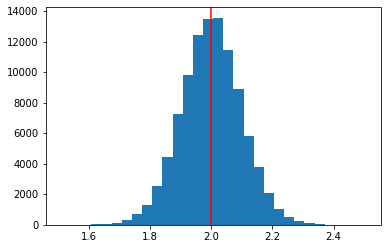

In [33]:
plt.hist(b1hat,bins=30)
plt.axvline(x=b1,color='red')
pass

`b1`の真の値`2.0`を中心に左右対象に分布している。

次に分布（ヒストグラム）のカーネル密度推定をおこなうために，`scipy.stats`にある`gaussian_kde`を使う。

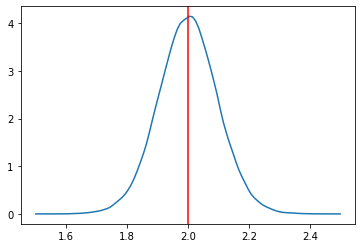

In [34]:
x=np.linspace(1.5,2.5,100)  # 図を作成するために-0.5から1.5までの横軸の値を設定
kde_model=gaussian_kde(b1hat)  # bhatのカーネル密度推定を設定
ufunc = kde_model(x)  # カーネル密度推定を使いb1hatの分布を推定

plt.plot(x, ufunc)  # 誤差項の分布をプロット
plt.axvline(x=b1,color='red')  # 母集団のパラメータ
pass

２つの図を重ねる。

（注意）ヒストグラムの縦軸は頻度である。一方，カーネル密度推定の場合，曲線の下の面積が１になるように縦軸が設定されている。ヒストグラムの縦軸をカーネル密度推定に合わせるために`density=True`のオプションを加える。

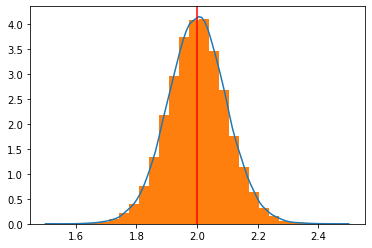

In [35]:
x=np.linspace(1.5,2.5,100)
kde_model=gaussian_kde(b1hat)
ufunc = kde_model(x)

plt.plot(x, ufunc)
plt.hist(b1hat,bins=30, density=True)
plt.axvline(x=b1,color='red')
pass

＜Give it a try!＞
* 標本の大きさ`n`を30、100、500の３つのケースでシミュレーションをおこない、それぞれのカーネル密度推定を重ねて１つの図を作成しなさい。
* $\hat{\beta}_0$と$\hat{\beta}_2$の分布も図示しなさい。
* `n`を変化させて違いを確かめなさい。
* `N`を変化させて違いを確かめなさい。

## シミュレーション：多重共線性

### 説明

多重共線性高まると，パラメータの推定値の正確性が低下する（即ち、パラメータの標準誤差$\text{se}\left(\hat{\beta}_j\right)$が大きくなる）。この点を確認するためにパラメータの分散の推定値にある

$$
\frac{1}{1-R_j^2}
$$

を利用する。これは**分散拡大因子（variance inflation factor）**と呼ばれる。この値が１０以上になる説明変数どうしを使うと多重共線性の可能性が高いといわれる。

例として回帰分析`res_1`を考える。

### 方法１：手計算

説明変数だけから構成される`DataFrame`を作成する。

In [36]:
wage1_vif = wage1.drop('wage', axis=1)

`corr()`は相関係数を返すメソッドであり，そこから`.values`を使い属性としてデータを`NumPy`の`array`として取り出す。

In [37]:
mc = wage1_vif.corr().values

* 上でも使ったが`linalg.inv()`は`NumPy`にある`linalg`サブパッケージの`inv()`（逆行列を返す関数）を使い逆関数を計算する。
* `diagonal()`は関数の対角成分を返すメソッドであり，それが`vif`。

In [38]:
vif_manual = np.linalg.inv(mc).diagonal()
vif_manual

array([1.11277075, 1.34929556, 1.47761777])

変数名と一緒に表示するために

In [39]:
pd.Series(vif_manual, index=wage1_vif.columns)

educ      1.112771
tenure    1.349296
exper     1.477618
dtype: float64

次に上の計算を関数にまとめる。

In [40]:
def my_vif(dataframe):
    mc = dataframe.corr().values
    vif = np.linalg.inv(mc).diagonal()
    return pd.Series(vif_manual, index=dataframe.columns)

my_vif(wage1_vif)

educ      1.112771
tenure    1.349296
exper     1.477618
dtype: float64

### 方法２：`statsmodels`

`statsmodels`にある`variance_inflation_factor`を使う。

必ず**定数項を含む**説明変数だけから構成される`DataFrame`を作成する。

In [41]:
wage1_vif['Intercept'] = 1.0

In [42]:
for i in range(len(wage1_vif.columns)-1):  # 定数項は無視するために-1
    print(wage1_vif.columns[i], '\t',vif(wage1_vif.values, i))

educ 	 1.1127707502838835
tenure 	 1.3492955605611776
exper 	 1.4776177726317783


定数項は考えなくて良い。

（コメント）上のコードにある`\t`は文字列の中でタブを入れる場合に使う。

### シミュレーション

多重共線性により，`OLS`推定量の標準誤差が上昇し推定量の正確性が損なわれることを確認する。

シミュレーションでは以下の回帰式を使う。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u$$

シミュレーションの関数を作成する。
* 引数
    * `n`：標本の大きさ`
    * `N`：標本数（ループの回数）の
    * `m`：２つの説明変数の共分散
* 返り値
    * $\hat{\beta}_i$，$i=0,1,2$の推定値のリスト
    
（コメント）

* `@njit`を使いたいところだが，`numpy`の`random.multivariate_normal()`が`Numba`に対応していないため`scipy.stats`の `multivariate_normal.rvs()`を使っている。`np.random.normal()`を使って二変量正規分布から値とする方法もあるが，ここでは簡単化を重視する。
* 計算の速度を早めるために下の関数の中では`ols`は使わず`numpy`の関数を使いIVとOLS推定値を計算している。`ols`は係数の推定値だけではなく他の多くの統計値も自動的に計算するために一回の計算に比較的に長い時間を要するためである。

In [43]:
def sim_multi(n, N, m):  # n=標本の大きさ, N=標本数, m=共分散
    
    # ２つのx1,x2の共分散を設定
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
               [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れる空のリスト
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # x1, x2の値の抽出
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数

        u = np.random.randn(n)  # 標準正規分布
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]  # b0hat_listへの追加
        b1hat_arr[i] = bhat[1]  # b1hat_listへの追加
        b2hat_arr[i] = bhat[2]  # b2hat_listへの追加

    return b0hat_arr, b1hat_arr, b2hat_arr # 返り値の設定

シミュレーションの開始

In [44]:
# 多重共線性が弱いケース 
b0hat_weak, b1hat_weak, b2hat_weak = sim_multi(30, 10_000, m=0.1)

# 多重共線性が強いケース 
b0hat_strong, b1hat_strong, b2hat_strong = sim_multi(30, 10_000, m=0.9)

$\hat{\beta}_1$の分布の図示

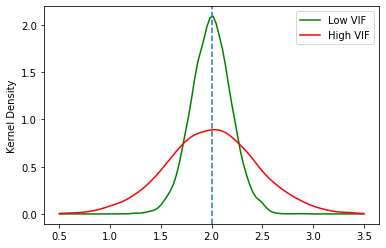

In [45]:
xx=np.linspace(0.5,3.5,num=100)  # 図を作成するために横軸の値を設定

# 多重共線性が弱いケース
kde_model_weak=gaussian_kde(b1hat_weak)  # OLS推定量のカーネル密度関数を計算

# 多重共線性が強いケース
kde_model_strong=gaussian_kde(b1hat_strong)

plt.plot(xx, kde_model_weak(xx), 'g-', label='Low VIF')  # OLS推定量の分布プロット
plt.plot(xx, kde_model_strong(xx),'r-', label='High VIF')  # IV推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

多重共線性が高いと推定値の分布は，真の値（$\beta_1=$
`0.5`）の周辺で低くなり左右に広がっている。推定値の正確性が低下することを示している。$\hat{\beta}_1$の分散を計算してみよう。

In [46]:
np.var(b1hat_weak), np.var(b1hat_strong)

(0.03925475681011201, 0.20270527733632177)

＜Give it a try!＞

以下のシミュレーションをおこない，違いは何か確認しなさい。
1. $\hat{\beta}_0$と$\hat{\beta}_2$の分布も図示しなさい。
1. `n`を変化させて違いを確かめなさい。
1. `N`を変化させて違いを確かめなさい。
1. `sim_multi`を書き換えて$\hat{\beta}_1$と$\hat{\beta}_2$の標準誤差をプロットし
1. 問4のそれぞれの平均を計算しなさい。（ヒント：推定結果の属性`bse`を使う）

問4の答え：$+$を押すと答えが表示される。

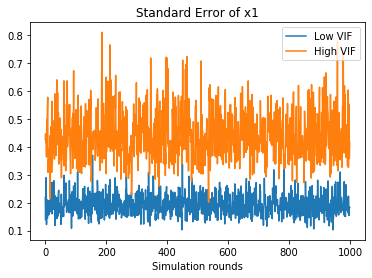

In [47]:
def sim_se(n, N, m, b0=1.0, b1=0.5, b2=1.5):  # n=標本の大きさ, N=標本数, m=共分散
    
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
              [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れるarray
    se_x1_arr = np.zeros(N)
    se_x2_arr = np.zeros(N)

    for i in range(N):  # N 回のループ
        
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数
        X = np.stack([np.ones(n),x1,x2],axis=1)  # 説明変数の行列    
        
        u = np.random.normal(loc=0, scale=1, size=n)  # 誤差項（標準正規分布）
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数

        bhat = np.linalg.inv((X.T)@X)@(X.T)@y # 係数の推定値
        yhat = X@bhat  # yの予測値
        uhat = y-yhat  # 残差
        rss = (uhat.T)@uhat  # 残差平方和
        sigma2 = rss/(n-3)  # 回帰の残差（不偏）分散 
        XTX_1 = np.linalg.inv(X.T@X)  # moment matrix
        variance = sigma2*np.diag(XTX_1)  # bの分散
        se = np.sqrt(variance)  # bの標準誤差
        
        se_x1_arr[i] = se[1]  # arrayに追加
        se_x2_arr[i] = se[2]  # array追加
        
    return se_x1_arr, se_x2_arr # 返り値の設定


# 多重共線性が弱いケース 
se_x1_weak, se_x1_weak = sim_se(30,1000,m=0.1)

# 多重共線性が強いケース 
se_x1_strong, se_x1_strong = sim_se(30,1000,m=0.9)


plt.plot(se_x1_weak, label='Low VIF')
plt.plot(se_x1_strong, label='High VIF')
plt.title('Standard Error of x1')
plt.xlabel('Simulation rounds')
plt.legend()
pass

問5の答え：$+$を押すと答えが表示される。

In [48]:
sum(se_x1_weak)/len(se_x1_weak), sum(se_x1_strong)/len(se_x1_strong)

# 次のコードでもOK
# np.array(se_x1_weak).mean(), np.array(se_x1_strong).mean()

(0.1939329235951929, 0.43985015208381206)

### 図を使ってチェック

多重共線性は説明変数間の相関が高いと発生するが，ここでは相関度を図を使ってチェックする。色々な方法があるが，以下では２つ紹介する。
1. `pandas`の関数`scatter_matrix`を使う方法
1. `seaborn`というパッケージの関数`pairplot`を使う方法

#### `pandas`を使う方法

まずコードの中で`matplotlib`明示的に導入せずに`pandas`のみを使い図示する方法を紹介する。こちらの方が簡単と感じるかもしれない。散布図を描いてみる。

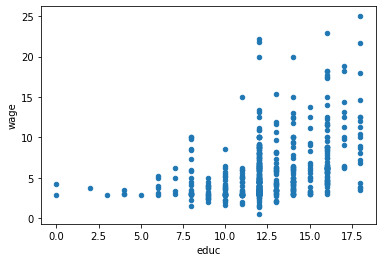

In [49]:
wage1.plot.scatter('educ','wage')
pass

`pandas`の`DataFrame`や`Series`には図を作成するメソッド`plot()`が用意されている（裏では`matplotlib`が動いている）。例えば，`wage1`にある`educ`のヒストグラムであれば次のコードで図示することができる。
```
wage1['educ'].plot(kind='hist')

もしくは

wage1['educ'].plot.hist()
```
また`educ`と`wage`の散布図は次のコードで描くことができる。
```
wage1.plot('educ','wage',kind='scatter')

もしくは

wage1.plot.scatter('educ','wage')
```

また１つの`DataFrame`にある複数列データを使い，複数の図を並べることも可能である。興味がある人は[このリンク](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)を参照しよう。

---
変数の相関度をチェックするために`pandas.plotting`の`scatter_matrix`を使う。このモジュールは`DataFrame`を引数とする。

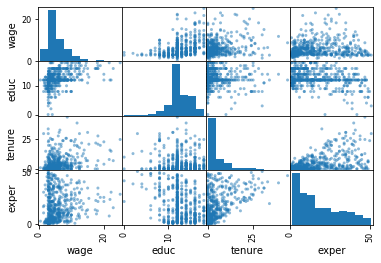

In [50]:
scatter_matrix(wage1)
pass

横軸と縦軸のラベルを確認すること。対角線上はそれぞれの変数のヒストグラム，対角線以外の図はそれぞれのペアの変数の散布図となっており，相関度をある程度目で確認できる。

---
次に主なオプションとして２つを紹介する。
1. 図の大きさは`figsize=(9, 6)`で指定する。この例では`9`が横幅，`6`が縦幅である。 
1. `diagonal='kde'`を指定すると対角線上のヒストグラムをカーネル密度推定に変更できる。

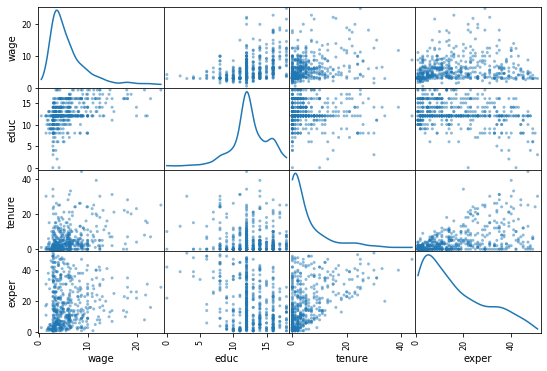

In [51]:
scatter_matrix(wage1, figsize=(9, 6), diagonal='kde')
pass

次に相関係数を簡単に計算する方法を紹介する。`DataFrame`のメソッド`corr()`を使うと変数の相関係数を自動的に表示される。

In [52]:
mat = wage1.corr()
mat

,wage,educ,tenure,exper
wage,1.000000,0.405903,0.346890,0.112903
educ,0.405903,1.000000,-0.056173,-0.299542
tenure,0.346890,-0.056173,1.000000,0.499291
exper,0.112903,-0.299542,0.499291,1.000000


上の図と相関係数の値を見比べて，概ねどのような関係にあるのかを確かめよう。

#### `seaborn`を使う方法

`seaborn`を使うとより「見栄えがする」図を描くことができる。`seaborn`については[このリンク](https://seaborn.pydata.org)を参照しよう。`seaborn`は`sns`としてインポートするのが慣例である。

まず上で`DataFrame`のメソッド`corr()`を使うと変数の相関係数を計算したが，`seaborn`の`heatmap()`関数を使うと相関係数を色に変換してより見やすい表示となる。

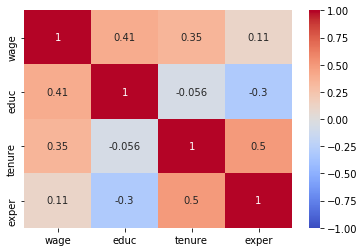

In [53]:
sns.heatmap(mat, vmin=-1, annot=True, cmap='coolwarm')
pass

赤はプラス，青はマイナスを示し，色の濃淡は絶対値に連動している。ここで使った３つのオプション（設定しなくても良い）の説明する。
* `vmin`：右の縦長の棒は表示される範囲を示すが，その最低値を`-1`にする（デフォルトは自動で設定）
    * 最高値を設定する`vmax`もあるが，`.corr()`の対角成分は`1`なので設定する必要はない。
* `annot`は相関係数を表示する（デフォルトは`False`）
* `cmap`は色を設定する（デフォルトは`None`）

`seaborn`には，`matplotlib`の相関度をチェックする`scatter_matrix`関数に対応する`pairplot`があり，より使い勝手が良いと感じるかもしれない。

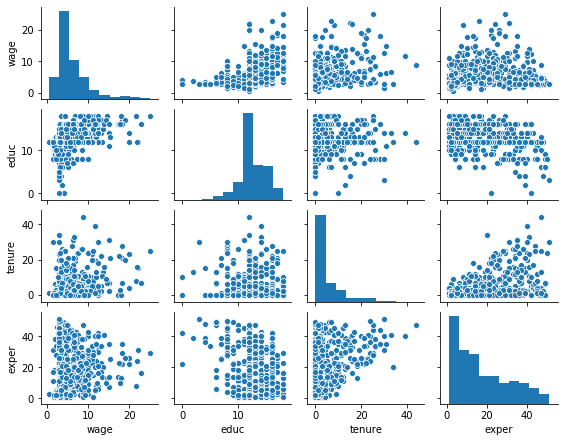

In [54]:
sns.pairplot(wage1, height=1.5, aspect=1.3)
pass

図の解釈は`pandas`の場合と同じである。

`pairplot()`の主な引数：
1. それぞれの図（ファセット）のサイズ
    * `height`は高さを指定
    * 横幅は`aspect`$\times$`height`で設定する。
1. 対角線上のヒストグラムをカーネル密度推定に変更する場合は`diag_kind=kde`と指定する。
1. `kind='reg'`を追加すると，散布図に回帰直線が追加され相関度の確認がより簡単になる。

`seaborn`の回帰分析に関係するプロットについては[このリンク](https://seaborn.pydata.org/tutorial/regression.html#regression-tutorial)が役立つだろう。